# 1. Downloading the data and adding it to a pandas dataframe

In [2]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [3]:
def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [4]:
def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

In [8]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [9]:
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [11]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [16]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

# 2. Preprocessing the data

## 2.1. Numerical Data

It is usefull for optimization to standarize the distribution of features into a 0 mean and 1 covariance distribution, by calculating the subtracting the mean and then dividing by the covariance of that feature. This is also important because a priori there is no information about which feature is more important. By standarizing the values, we do not penalize coefficients of any feature.

After standarization, we fill all empty values of all numerical features with zeros, as this is the mean of the distribution now.


In [17]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

## 2.2. Categorical data

We need to encode categorical data into one hot vectors. Pandas does this for us, with the get_dummies function. The variable dummy_na=True makes empty values a valid feature, and creates a vector for it.

This process will add a lot of features to the data, as a 3 category feature will be processed into three one hot vectors.

In [18]:
all_features = pd.get_dummies(all_features, dummy_na=True)

## 2.3. Store in torch tensors

In [27]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1),
                            dtype=torch.float32)

# 3. Simple Linear Model with MSE

In [23]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

We are interested in measuring are accuracy of the prediction not by the absolute error, but by the relative error given our data. Therefore we will calculate the log error.

In [20]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

## Training

In [21]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

We will use k-fold validation. First, a function that generates the i-th of k folds, next a function that trains fold by fold and averages the errors.

In [37]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [45]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size, graph=False, verbose=False):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0 and graph:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        if verbose:
            print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
                f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## Testing parameters

fold 1, train log rmse 0.170444, valid log rmse 0.157265
fold 2, train log rmse 0.162234, valid log rmse 0.191855
fold 3, train log rmse 0.163738, valid log rmse 0.168150
fold 4, train log rmse 0.167324, valid log rmse 0.154464
fold 5, train log rmse 0.163056, valid log rmse 0.183099
5-fold validation with 100 epochs, 5 learning rate, 0 weight decay and 64 batch size : avg train log rmse: 0.165359, avg valid log rmse: 0.170967


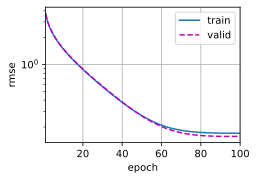

In [46]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size, True, True)
print(f'{k}-fold validation with {num_epochs} epochs,', f'{lr} learning rate,', 
        f'{weight_decay} weight decay and {batch_size} batch size',
      f': avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

In [53]:
num_epochs, lr, weight_decay, batch_size = 100, 5, 0, 64
ks = list(range(2,100,5))
train_ls = []
valid_ls = []
for k in ks:
  train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
  train_ls.append(train_l)
  valid_ls.append(valid_l)

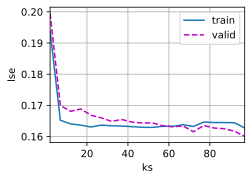

In [56]:
d2l.plot(ks, [train_ls, valid_ls],
                     xlabel='ks', ylabel='lse', xlim=[2, max(ks)],
                     legend=['train', 'valid'])